In [15]:
import os, time
import numpy as np
import pandas as pd
import joblib

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)


In [16]:
DATA_DIR = r"C:\Users\aparn\Downloads\adult (1)"
TRAIN_PATH = os.path.join(DATA_DIR, "adult.data")
TEST_PATH  = os.path.join(DATA_DIR, "adult.test")

ARTIFACT_DIR = os.path.join(DATA_DIR, "artifacts")
os.makedirs(ARTIFACT_DIR, exist_ok=True)

SEED = 42
np.random.seed(SEED)


In [ ]:
COLS = [
    "age","workclass","fnlwgt","education","education-num","marital-status",
    "occupation","relationship","race","sex","capital-gain","capital-loss",
    "hours-per-week","native-country","income"
]


In [17]:
def load_adult(path):
    df = pd.read_csv(
        path,
        header=None,
        names=COLS,
        na_values=" ?",
        skipinitialspace=True,
        comment='|'
    )
    df = df.dropna(how="all")
    df = df[df['age'].astype(str).str.isnumeric()]
    df = df.reset_index(drop=True)
    df['income'] = df['income'].astype(str).str.strip().str.rstrip('.')
    return df


In [18]:
train_df = load_adult(TRAIN_PATH)
test_df  = load_adult(TEST_PATH)

for df in (train_df, test_df):
    df['target'] = (df['income'].str.strip() == ">50K").astype(int)
    df.drop(columns=['income'], inplace=True)


In [19]:
numeric_features = [
    "age","fnlwgt","education-num",
    "capital-gain","capital-loss","hours-per-week"
]

categorical_features = [
    c for c in train_df.columns
    if c not in numeric_features + ['target']
]


In [20]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])


In [21]:
X_train_full = train_df.drop(columns=['target'])
y_train_full = train_df['target'].values

X_test = test_df.drop(columns=['target'])
y_test = test_df['target'].values

preprocessor.fit(X_train_full)

X_train_full_proc = preprocessor.transform(X_train_full)
X_test_proc = preprocessor.transform(X_test)

joblib.dump(preprocessor, os.path.join(ARTIFACT_DIR, "adult_preprocessor.joblib"))


['C:\\Users\\aparn\\Downloads\\adult (1)\\artifacts\\adult_preprocessor.joblib']

In [22]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full_proc,
    y_train_full,
    test_size=0.15,
    random_state=SEED,
    stratify=y_train_full
)


In [23]:
use_tf = True
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    tf.random.set_seed(SEED)
except Exception:
    use_tf = False


In [24]:
if use_tf:
    batch_size = 128

    def make_dataset(X, y, batch_size=128, shuffle=False):
        ds = tf.data.Dataset.from_tensor_slices(
            (X.astype('float32'), y.astype('float32'))
        )
        if shuffle:
            ds = ds.shuffle(min(10000, X.shape[0]), seed=SEED)
        return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [25]:
    def build_mlp(input_dim, hidden=(256,128,64), dropout=0.4):
        inp = keras.Input(shape=(input_dim,))
        x = inp
        for units in hidden:
            x = layers.Dense(units)(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)
            x = layers.Dropout(dropout)(x)
        x = layers.Dense(1, activation='sigmoid')(x)
        return keras.Model(inp, x)


In [26]:
    train_ds = make_dataset(X_train, y_train, shuffle=True)
    val_ds   = make_dataset(X_val, y_val)
    test_ds  = make_dataset(X_test_proc, y_test)

    model = build_mlp(X_train.shape[1])

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC()]
    )

    callbacks = [
        keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=3)
    ]

    model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks)


Epoch 1/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.7862 - auc: 0.8329 - loss: 0.4431 - precision: 0.5489 - recall: 0.6287 - val_accuracy: 0.8561 - val_auc: 0.9132 - val_loss: 0.3281 - val_precision: 0.7044 - val_recall: 0.6930 - learning_rate: 0.0010
Epoch 2/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8382 - auc: 0.8890 - loss: 0.3472 - precision: 0.6842 - recall: 0.6093 - val_accuracy: 0.8600 - val_auc: 0.9168 - val_loss: 0.3089 - val_precision: 0.7169 - val_recall: 0.6913 - learning_rate: 0.0010
Epoch 3/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8421 - auc: 0.8983 - loss: 0.3329 - precision: 0.6941 - recall: 0.6161 - val_accuracy: 0.8602 - val_auc: 0.9187 - val_loss: 0.3066 - val_precision: 0.7255 - val_recall: 0.6743 - learning_rate: 0.0010
Epoch 4/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8461 - auc: 0.9008 - loss: 0.3297 - precision: 0.7082 - recall: 0.6143 - val_accuracy: 0.8594 - val_auc: 0.9184 - val_loss: 0.3048 - 

In [27]:
    probs = model.predict(test_ds).ravel()
    preds = (probs >= 0.5).astype(int)

    print(classification_report(y_test, preds, target_names=['<=50K','>50K']))
    print(confusion_matrix(y_test, preds))

    pd.DataFrame({
        "true": y_test,
        "pred": preds,
        "prob": probs
    }).to_csv(os.path.join(ARTIFACT_DIR, "adult_test_predictions.csv"), index=False)

    model.save(os.path.join(ARTIFACT_DIR, "adult_mlp_model.keras"))


128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

       <=50K       0.89      0.93      0.91     12435
        >50K       0.74      0.61      0.67      3846

    accuracy                           0.86     16281
   macro avg       0.82      0.77      0.79     16281
weighted avg       0.85      0.86      0.85     16281

[[11622   813]
 [ 1488  2358]]


In [31]:
else:
    from sklearn.linear_model import LogisticRegression

    clf = LogisticRegression(solver='saga', max_iter=2000)
    clf.fit(X_train, y_train)

    probs = clf.predict_proba(X_test_proc)[:,1]
    preds = (probs >= 0.5).astype(int)

    print(classification_report(y_test, preds))
    print(confusion_matrix(y_test, preds))

    joblib.dump(clf, os.path.join(ARTIFACT_DIR, "adult_logreg_fallback.joblib"))



SyntaxError: invalid syntax (3732377029.py, line 1)

In [32]:
print("Artifacts saved to:", ARTIFACT_DIR)


Artifacts saved to: C:\Users\aparn\Downloads\adult (1)\artifacts


In [33]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve,
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


In [34]:
if 'y_test' not in globals() or 'preds' not in globals() or 'probs' not in globals():
    raise RuntimeError(
        "y_test, preds, probs must exist. "
        "Run the training notebook or load saved predictions first."
    )

if 'ARTIFACT_DIR' not in globals():
    ARTIFACT_DIR = os.getcwd()

os.makedirs(ARTIFACT_DIR, exist_ok=True)
print("Artifacts will be saved to:", ARTIFACT_DIR)


Artifacts will be saved to: C:\Users\aparn\Downloads\adult (1)\artifacts


In [35]:
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

prec_curve, recall_curve, _ = precision_recall_curve(y_test, probs)
pr_auc = auc(recall_curve, prec_curve)


In [36]:
acc  = accuracy_score(y_test, preds)
prec = precision_score(y_test, preds, zero_division=0)
rec  = recall_score(y_test, preds, zero_division=0)
f1   = f1_score(y_test, preds, zero_division=0)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")


Accuracy : 0.8587
Precision: 0.7436
Recall   : 0.6131
F1-score : 0.6721


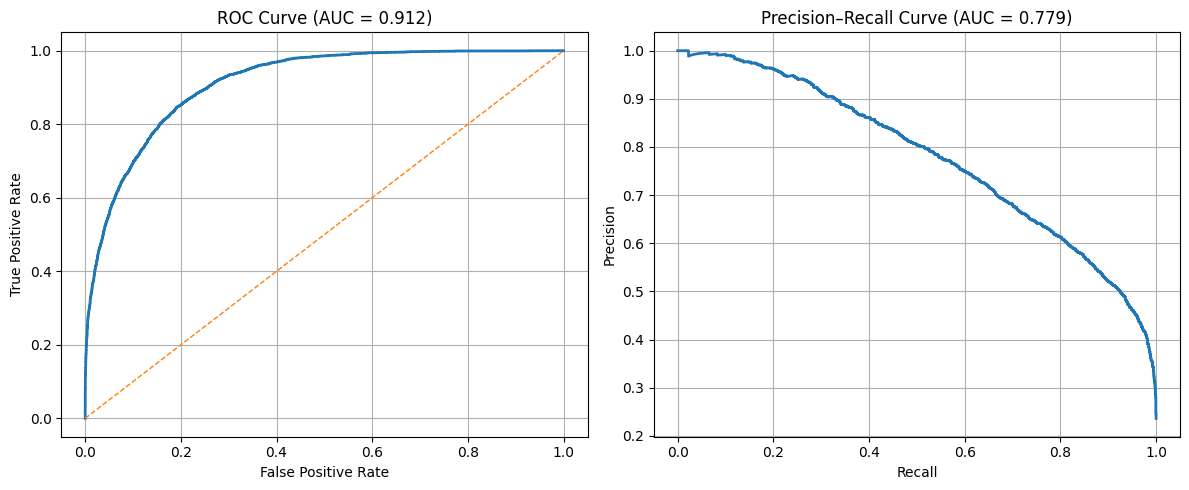

Saved: C:\Users\aparn\Downloads\adult (1)\artifacts\roc_pr_curves.png


In [37]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve
ax1.plot(fpr, tpr, lw=2)
ax1.plot([0,1], [0,1], linestyle='--', lw=1)
ax1.set_title(f"ROC Curve (AUC = {roc_auc:.3f})")
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.grid(True)

# Precision-Recall Curve
ax2.plot(recall_curve, prec_curve, lw=2)
ax2.set_title(f"Precision–Recall Curve (AUC = {pr_auc:.3f})")
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.grid(True)

plt.tight_layout()
roc_png = os.path.join(ARTIFACT_DIR, "roc_pr_curves.png")
fig1.savefig(roc_png, dpi=200)
plt.show()

print("Saved:", roc_png)


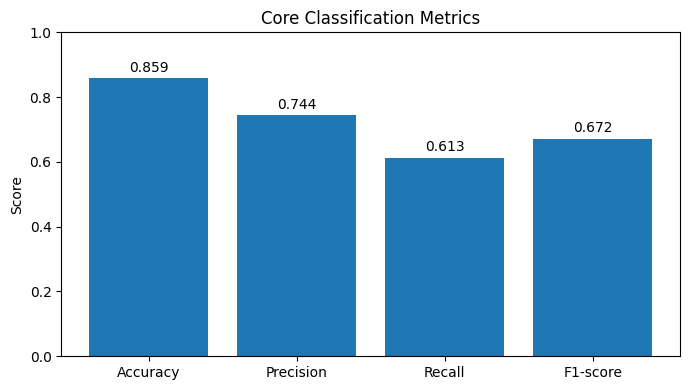

Saved: C:\Users\aparn\Downloads\adult (1)\artifacts\core_metrics_bars.png


In [38]:
metrics_names = ["Accuracy", "Precision", "Recall", "F1-score"]
metrics_values = [acc, prec, rec, f1]

fig2, ax = plt.subplots(figsize=(7, 4))
bars = ax.bar(metrics_names, metrics_values)
ax.set_ylim(0, 1)
ax.set_title("Core Classification Metrics")
ax.set_ylabel("Score")

for bar, val in zip(bars, metrics_values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.02, f"{val:.3f}", ha='center')

plt.tight_layout()
metrics_png = os.path.join(ARTIFACT_DIR, "core_metrics_bars.png")
fig2.savefig(metrics_png, dpi=200)
plt.show()

print("Saved:", metrics_png)


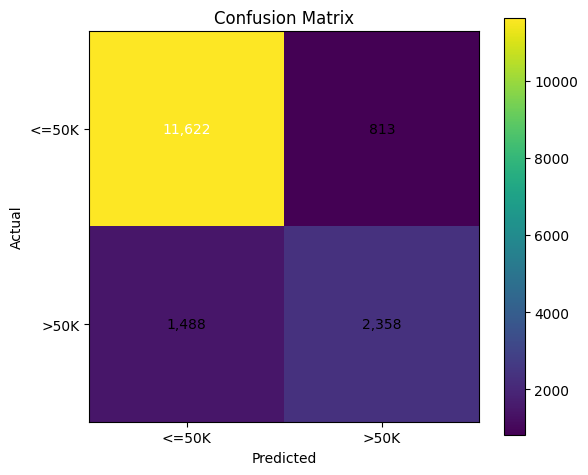

Saved: C:\Users\aparn\Downloads\adult (1)\artifacts\confusion_matrix_colorful.png


In [39]:
cm = confusion_matrix(y_test, preds)
labels = ['<=50K', '>50K']

fig3, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap=plt.cm.viridis)

ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i,j]:,}",
                ha="center", va="center",
                color="white" if cm[i,j] > thresh else "black")

fig3.colorbar(im, ax=ax)
plt.tight_layout()

cm_png = os.path.join(ARTIFACT_DIR, "confusion_matrix_colorful.png")
fig3.savefig(cm_png, dpi=200)
plt.show()

print("Saved:", cm_png)


In [40]:
report_dict = classification_report(
    y_test, preds, output_dict=True, zero_division=0
)

report_df = pd.DataFrame(report_dict).T

for col in ['precision', 'recall', 'f1-score']:
    if col in report_df.columns:
        report_df[col] = report_df[col].astype(float).round(3)

if 'support' in report_df.columns:
    report_df['support'] = report_df['support'].astype(int)

class_rows = [r for r in report_df.index if r not in ('accuracy','macro avg','weighted avg')]
bottom_rows = [r for r in ('accuracy','macro avg','weighted avg') if r in report_df.index]
report_df = report_df.loc[class_rows + bottom_rows]

report_csv = os.path.join(ARTIFACT_DIR, "classification_report_table.csv")
report_df.to_csv(report_csv)

print("Saved:", report_csv)
report_df


Saved: C:\Users\aparn\Downloads\adult (1)\artifacts\classification_report_table.csv


,precision,recall,f1-score,support
0,0.886,0.935,0.910,12435
1,0.744,0.613,0.672,3846
accuracy,0.859,0.859,0.859,0
macro avg,0.815,0.774,0.791,16281
weighted avg,0.853,0.859,0.854,16281


In [41]:
styled = (
    report_df.style
    .background_gradient(subset=['f1-score'], cmap='viridis')
    .format({"precision":"{:.3f}", "recall":"{:.3f}", "f1-score":"{:.3f}"})
    .set_caption("Classification Report")
)

html_path = os.path.join(ARTIFACT_DIR, "classification_report_table.html")
with open(html_path, "w", encoding="utf-8") as f:
    f.write(styled.render())

print("Saved:", html_path)


AttributeError: 'Styler' object has no attribute 'render'

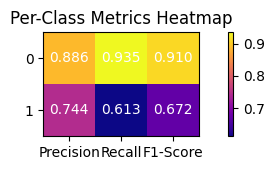

Saved: C:\Users\aparn\Downloads\adult (1)\artifacts\classification_report_heatmap.png


In [43]:
plot_df = report_df.loc[class_rows, ['precision','recall','f1-score']]

fig4, ax4 = plt.subplots(figsize=(6, 0.9 * len(plot_df)))
im = ax4.imshow(plot_df.values, cmap=plt.cm.plasma)

ax4.set_yticks(range(len(plot_df.index)))
ax4.set_yticklabels(plot_df.index)
ax4.set_xticks(range(len(plot_df.columns)))
ax4.set_xticklabels([c.title() for c in plot_df.columns])

ax4.set_title("Per-Class Metrics Heatmap")

for i in range(plot_df.shape[0]):
    for j in range(plot_df.shape[1]):
        ax4.text(j, i, f"{plot_df.iat[i,j]:.3f}",
                 ha='center', va='center',
                 color='white' if plot_df.iat[i,j] > plot_df.values.max()/2 else 'black')

fig4.colorbar(im, ax=ax4)
plt.tight_layout()

heatmap_png = os.path.join(ARTIFACT_DIR, "classification_report_heatmap.png")
fig4.savefig(heatmap_png, dpi=200)
plt.show()

print("Saved:", heatmap_png)
